In [1]:
from food.tools import *
from food.paths import *
from food.psql import *
import numpy as np
import torch
from torch.nn import CosineSimilarity
import requests
from food.qdrant import *
cos = CosineSimilarity(dim=1, eps=1e-08)
import pandas as pd

In [2]:
#export
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [3]:
collection_name = 'food'
table = 'foods'
foods = read_sql(table)
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [4]:
url = 'http://glovo.away.guru/photos_resized/NZTCKFL_0076494_1516096262.png'
image_clip,df = search_image(url,head=100)

In [5]:
selected = df.copy()

In [6]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

/tmp/ipykernel_1849641/588996549.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [7]:
selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    T = torch.cat([clip[0:i], clip[i+1:]])
    testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if testscore > initscore: 
        r = selected.loc[i,'description']
        selected = selected.drop(i)
        initscore = testscore
        # print(f"removed {r}")
    else:
        T = torch.cat([clip, clip[i].reshape(1,768)])
        testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if testscore > initscore: 
            selected = selected.append(selected.loc[i])
            # print(f"added {selected.loc[i,'description']}")
            initscore = testscore

    



print(initscore)
count = selected.groupby('description')['clip'].count().sort_index()
r = selected.drop_duplicates('description').set_index("description").sort_index()
r['count'] = count
r.sort_values('count',ascending = False)

tensor([0.2846], dtype=torch.float64)


,id,category,energy,protein,carb,fat,clip,score,count
description,,,,,,,,,
"Apple juice, 100%, with calcium added",1102748,Apple juice,48.0,0.12,11.49,0.17,"[0.01414635, 0.006959528, 0.0035419979, 0.0569...",0.230542,2
Nutrition bar (Balance Original Bar),1101259,Nutrition bars,415.0,28.00,48.73,12.00,"[-0.01209534, 0.0036753116, 0.058078367, -0.00...",0.202616,2
"Muffin, English, with fruit other than raisins",1100732,Bagels and English muffins,243.0,9.31,47.63,1.80,"[-0.018083451, -0.0061937105, 0.050549187, 0.0...",0.206761,2
"Kohlrabi, raw",1103356,Other vegetables and combinations,27.0,1.70,6.20,0.10,"[0.046535134, -0.025247127, -0.0028286164, -0....",0.205997,2
"Halvah, plain",1104068,Candy not containing chocolate,521.0,7.98,57.36,32.04,"[0.015021525, 0.045297496, 0.011053128, 0.0089...",0.208304,2
"Pie, apple, individual size or tart",1101062,Cakes and pies,316.0,3.00,42.60,16.10,"[0.038439795, 0.007134675, 0.031249179, 0.0065...",0.232672,2
Gin,1104487,Liquor and cocktails,231.0,0.00,0.00,0.00,"[0.0077090804, -0.0048638433, 0.041360896, -0....",0.199616,2
"Fritter, apple",1101153,"Doughnuts, sweet rolls, pastries",381.0,6.46,34.75,24.46,"[0.057608202, 0.031312082, 0.02672885, -0.0110...",0.258467,2
"Apple, baked",1102649,Apples,112.0,0.32,22.70,3.04,"[0.02772038, -0.01954301, 0.027409052, -0.0049...",0.255700,2


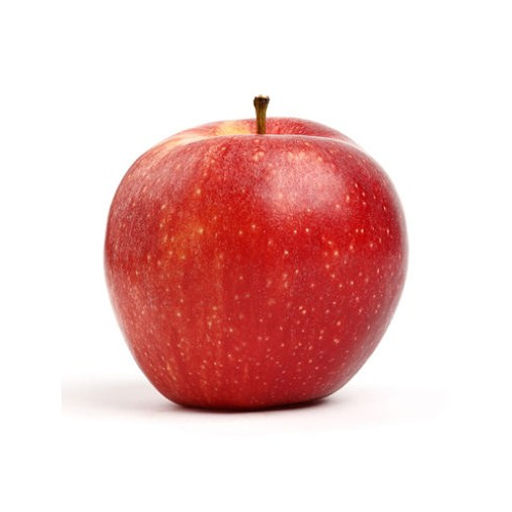

In [8]:
read_image_from_url(url)

use prompts sand alterations to dish names

In [25]:
url = 'http://glovo.away.guru/photos_resized/NZTCKFL_0076494_1516096262.png'

In [26]:
# url = 'https://image.shutterstock.com/image-photo/smorrebrod-traditional-danish-sandwiches-long-600w-1907860309.jpg'
image_clip,df = search_image(url,head=100)

In [41]:
selected = df.copy()

In [42]:
selected['altered_description'] = 'I am going to eat some ' +selected['description'].str.split(',').apply(lambda l:' '.join(list(reversed(l)))) + ' which blongs to ' + selected['category'] #selected['category']#+' '+selected['description'].str.replace(',','') I am going to eat some 

In [43]:
selected

,id,description,category,energy,protein,carb,fat,clip,score,altered_description
0,1102644,"Apple, raw",Apples,52.0,0.26,13.81,0.17,"[0.03289434, 0.009451146, 0.04302109, -0.00526...",0.274602,I am going to eat some raw Apple which blongs...
1,1101153,"Fritter, apple","Doughnuts, sweet rolls, pastries",381.0,6.46,34.75,24.46,"[0.057608202, 0.031312082, 0.02672885, -0.0110...",0.258467,I am going to eat some apple Fritter which bl...
2,1102649,"Apple, baked",Apples,112.0,0.32,22.70,3.04,"[0.02772038, -0.01954301, 0.027409052, -0.0049...",0.255700,I am going to eat some baked Apple which blon...
3,1101181,"Turnover or dumpling, apple",Cakes and pies,348.0,3.64,43.55,18.08,"[0.047357026, 0.0405507, -0.015996952, -0.0136...",0.246986,I am going to eat some apple Turnover or dump...
4,1102782,"Apples, baby food, toddler",Baby food: fruit,50.0,0.19,11.56,0.36,"[0.0003478544, -0.022820584, 0.033641424, 0.00...",0.245114,I am going to eat some toddler baby food App...
...,...,...,...,...,...,...,...,...,...,...
95,1103288,"Tomato and vegetable juice, 100%",Vegetable juice,22.0,0.93,3.87,0.31,"[0.03134079, 0.023050051, 0.0139320195, 0.0197...",0.200651,I am going to eat some 100% Tomato and vegeta...
96,1103813,"Vegetable and fruit juice, 100% juice, with hi...",Other fruit juice,46.0,0.30,11.15,0.01,"[0.011157938, 0.048245464, 0.0036253047, 0.057...",0.200449,I am going to eat some with high vitamin C 1...
97,1100865,"Muffin, fruit, low fat","Biscuits, muffins, quick breads",255.0,4.23,50.05,4.22,"[0.0011837828, 0.00715228, 0.029665468, -0.004...",0.200284,I am going to eat some low fat fruit Muffin ...
98,1103343,"Cabbage, red, raw",Cabbage,31.0,1.43,7.37,0.16,"[0.067335136, 0.014064836, -0.0027001977, -0.0...",0.199914,I am going to eat some raw red Cabbage which...


In [44]:
clip = []
for i in selected.index:
    text = selected.loc[i,'altered_description']
    clip.append(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())
selected['clip'] = clip

In [45]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

In [55]:

selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    T = torch.cat([clip, clip[i].reshape(1,768)])
    testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if testscore > initscore: 
        selected = selected.append(selected.loc[i])
        
        # print(f"added {selected.loc[i,'description']}")
        initscore = testscore
    else:

        T = torch.cat([clip[0:i], clip[i+1:]])
        testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if testscore > initscore: 
            r = selected.loc[i,'altered_description']
            selected = selected.drop(i)
            initscore = testscore
            # print(f"removed {r}")




print(initscore)
count = selected.groupby('altered_description')['clip'].count().sort_index()
r = selected.drop_duplicates('altered_description').set_index("altered_description").sort_index()
r['count'] = count
r = r.sort_values('count',ascending = False)
r['cumcount'] = r['count'].cumsum()/r['count'].sum()
r

tensor([0.2690], dtype=torch.float64)


,id,description,category,energy,protein,carb,fat,clip,score,count,cumcount
altered_description,,,,,,,,,,,
I am going to eat some raw Apple which blongs to Apples,1102644,"Apple, raw",Apples,52.0,0.26,13.81,0.17,"[0.025421161204576492, 0.036097947508096695, 0...",0.274602,16,0.551724
I am going to eat some junior baby food Dutch apple dessert which blongs to Baby food: snacks and sweets,1102867,"Dutch apple dessert, baby food, junior",Baby food: snacks and sweets,79.0,0.20,19.18,0.16,"[0.008863253518939018, -0.016027363017201424, ...",0.209188,4,0.689655
I am going to eat some with calcium added 100% Apple juice which blongs to Apple juice,1102748,"Apple juice, 100%, with calcium added",Apple juice,48.0,0.12,11.49,0.17,"[0.014394859783351421, -0.009781846776604652, ...",0.230542,4,0.827586
I am going to eat some candied Apple which blongs to Apples,1102721,"Apple, candied",Apples,134.0,1.34,29.61,2.15,"[0.03971079736948013, 0.0382964052259922, 0.01...",0.240039,2,0.896552
"I am going to eat some Cereal (General Mills Cheerios Apple Cinnamon) which blongs to Ready-to-eat cereal, higher sugar (>21.2g/100g)",1101693,Cereal (General Mills Cheerios Apple Cinnamon),"Ready-to-eat cereal, higher sugar (>21.2g/100g)",386.0,8.30,79.90,6.09,"[0.06687919795513153, 0.026330869644880295, -0...",0.221832,2,0.965517
I am going to eat some raw Nectarine which blongs to Peaches and nectarines,1102673,"Nectarine, raw",Peaches and nectarines,39.0,1.06,9.18,0.28,"[0.04510404169559479, 0.031627148389816284, 0....",0.230622,1,1.000000


In [56]:
selected['energy'].mean()

83.41379310344827

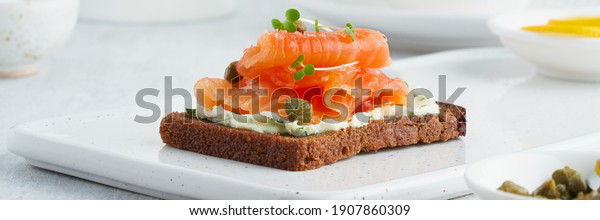

In [18]:
read_image_from_url(url)

In [465]:
selected['energy'].mean()

185.0